In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure

In [15]:
project_dir = '../..'

In [16]:
DATA = np.load(f'{project_dir}/outputs/julia2018_resting_timeseries.npz')

TR = 2  # in seconds

timeseries = DATA['timeseries']
subjects = DATA['subjects']
subject_groups = np.vectorize(lambda x: x[:4])(subjects)  # subject_id's first 4 characters 
ROI_labels = DATA['labels']
ROI_coords = DATA['coords']

print("Loaded {} subjects with {} timepoints for {} ROIs.".format(*timeseries.shape))

Loaded 32 subjects with 125 timepoints for 39 ROIs.


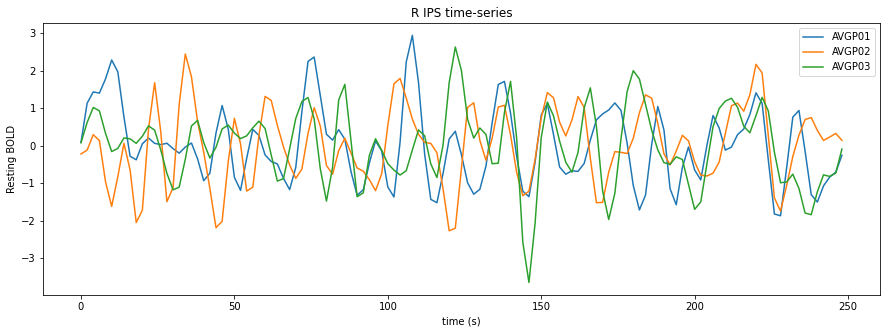

In [17]:
ROI_index_to_plot = 0
signal = timeseries[:,:,ROI_index_to_plot]

timepoints = np.arange(0,timeseries.shape[1] * TR, step=TR)

fig, ax = plt.subplots(1, figsize=(15, 5))

ax.set(title='{} time-series'.format(ROI_labels[ROI_index_to_plot]),
       xlabel='time (s)', ylabel='Resting BOLD')
for i, s in enumerate(subjects[:3]):
    sns.lineplot(timepoints, signal[i], ax=ax, label=s)

plt.show()

[Text(0.5, 0, 'Frequency (Hz)'), Text(0, 0.5, 'Magnitude')]

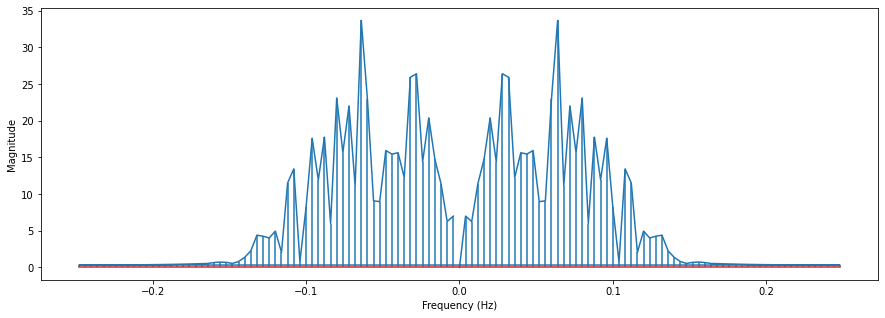

In [18]:
from scipy import fftpack

subject = 0
ROI_index = 0
signal = timeseries[subject,:,ROI_index]

samping_rate = 1/TR
X = fftpack.fft(signal)
freqs = fftpack.fftfreq(len(signal)) * samping_rate

fig, ax = plt.subplots(figsize=(15,5))

ax.stem(freqs, np.abs(X), markerfmt='')
ax.set(xlabel='Frequency (Hz)', ylabel='Magnitude')

# plt.show()

In [88]:
def mean_connectome(timeseries):
    cm = ConnectivityMeasure(kind='correlation')
    connectomes = cm.fit_transform(timeseries)

    # visualize average connectome
    mean_conn = cm.mean_
    np.fill_diagonal(mean_conn, 0)  # improves visualization!

    # disp = plotting.plot_connectome(mean_conn, ROI_coords,
    #                                 edge_threshold="90%",
    #                                 colorbar=True)
    return mean_conn

bootstrapped_conns = []
boot_clusters = []

for i in range(1000):
    boot_subjs = np.random.choice(len(subjects), replace=True, size=len(subjects))
    conn = mean_connectome(timeseries[boot_subjs,:])
    distances = 1.0 - conn
    linkages = linkage(distances, 'average')
    clusters = fcluster(linkages, t=8, criterion='maxclust')
    boot_clusters.append(clusters)
    bootstrapped_conns.append(conn)

boot_clusters = np.asarray(boot_clusters)


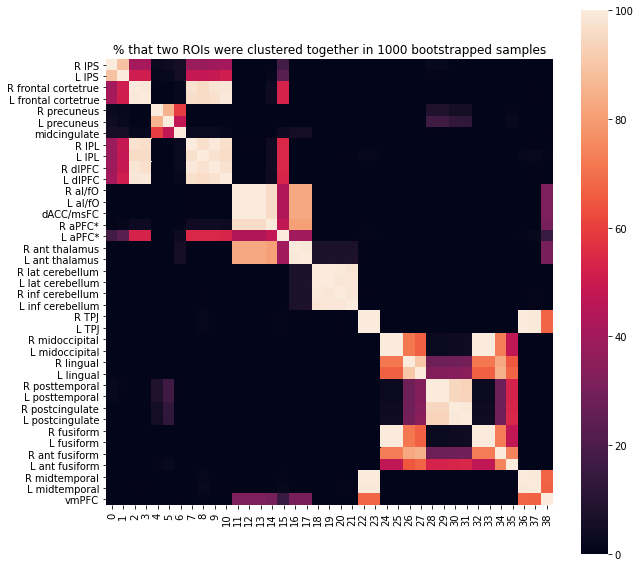

In [93]:
# number of times given nodes was clustered with each other nodes (out of 1000)

n_ROIs = ROI_labels.shape[0]
boot_clustered=np.zeros((n_ROIs,n_ROIs))
for i in range(39):
    boot_clustered[i,i] = 100
    for j in range(i):
        boot_clustered[j,i] = boot_clustered[i,j] = np.sum(boot_clusters[:,i] == boot_clusters[:,j]) / 10.

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(boot_clustered, square=True, yticklabels=ROI_labels, ax=ax)
ax.set(title='% that two ROIs were clustered together in 1000 bootstrapped samples')
plt.show()

Figure below shows clusters of group-averaged connectome in 1000 bootstrapped samples.

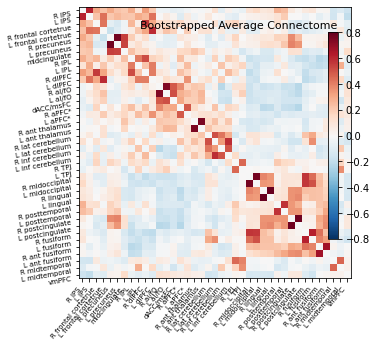

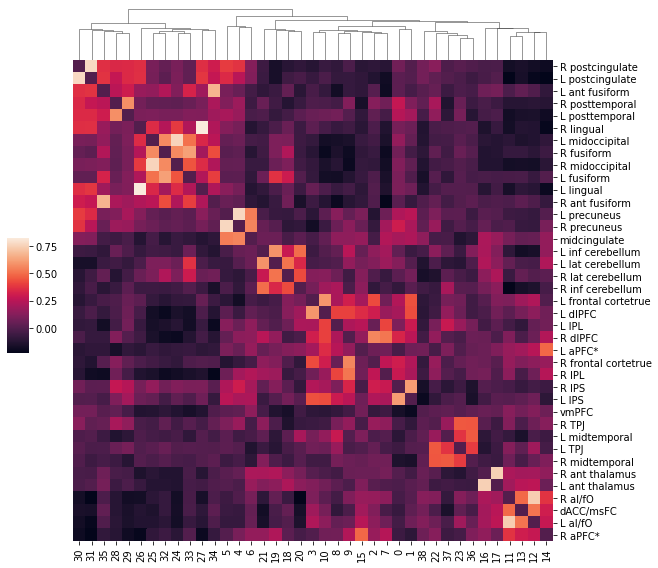

In [85]:
mean_conn = np.mean(bootstrapped_conns, axis=0)

plotting.plot_matrix(mean_conn, labels=ROI_labels,
                     title='Bootstrapped Average Connectome',
                    vmax=.8, vmin=-0.8,
                    colorbar=True)

plt.show()

g = sns.clustermap(mean_conn,
                   dendrogram_ratio=(.2, .1),
                   cbar_pos=(.09, .38, .03, .2),
                   method='average', yticklabels=ROI_labels, figsize=(10,8))
g.ax_row_dendrogram.remove()
#g.ax_heatmap.get_xaxis().set_ticks([])
plt.show()

TODO:

- [ ]  Replicate Boostrapped CI (as in figure 9)